# Monte Carlo Detection Deep Dive

In [37]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats        
from scalecast.Forecaster import Forecaster
from scalecast.AnomalyDetector import AnomalyDetector
from scalecast.SeriesTransformer import SeriesTransformer

In [38]:
sns.set(rc={'figure.figsize':(12,8)})

In [39]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start='1959-01-01',
    end='2022-05-01',
).reset_index()

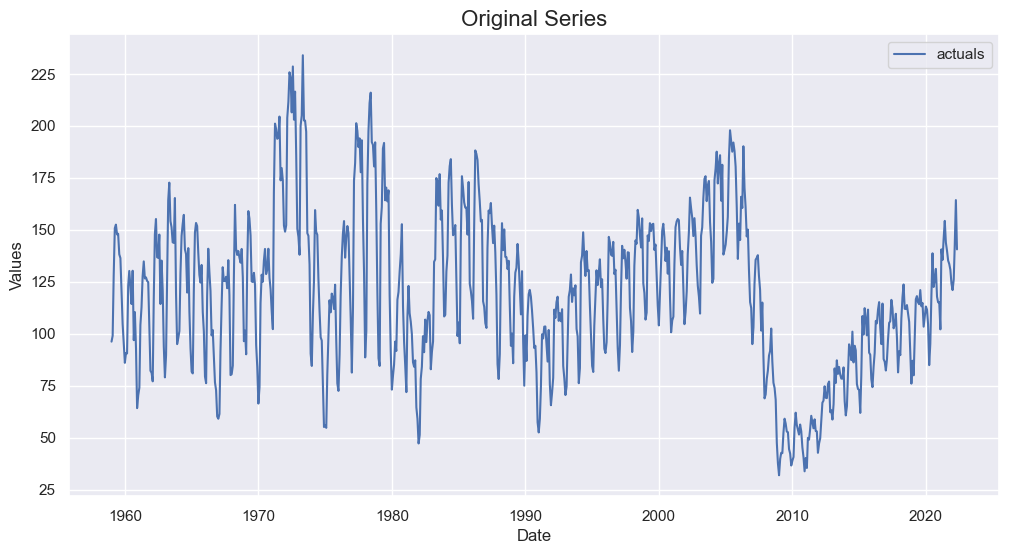

In [40]:
f = Forecaster(
    y=df['HOUSTNSA'],
    current_dates=df['DATE']
)

f.plot()
plt.title('Original Series',size=16)
plt.show()

## Monte Carlo Detect

This is a Monte Carlo simulated method that produces possible future paths for the data over some time span and uses a confidence interval to evaluate what percent of the time the actual data fell above or below the simulated paths. To make this method work properly, we should transform the distribution so that we can make it as stationary and normally distributed as possible. Therefore, extra care will be taken to prepare the data before applying the method.

To get started, we can transform the dataset so that a log transformation is taken to normalize some of the skew in the dataset, then a seasonal difference of 12 months is applied on the data, then the first difference of the resulting series is applied.

In [42]:
transformer = SeriesTransformer(f)

transformer.LogTransform()     # log transform
transformer.DiffTransform(12)  # seasonally adjust
f2 = transformer.DiffTransform(1)   # first difference

detector = AnomalyDetector(f2)

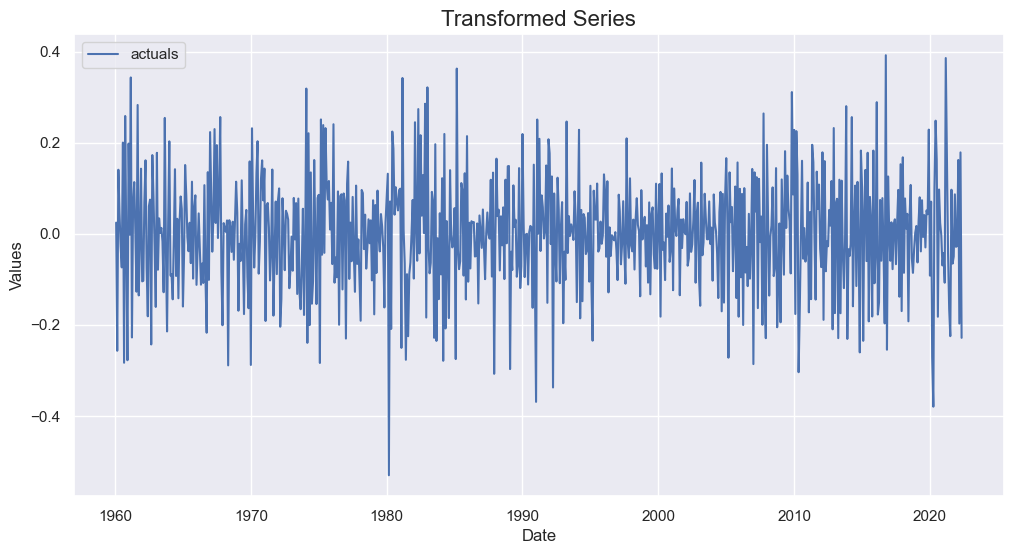

In [43]:
f2.plot()
plt.title('Transformed Series',size=16)
plt.show()

Call a histogram to make sure it looks normal:

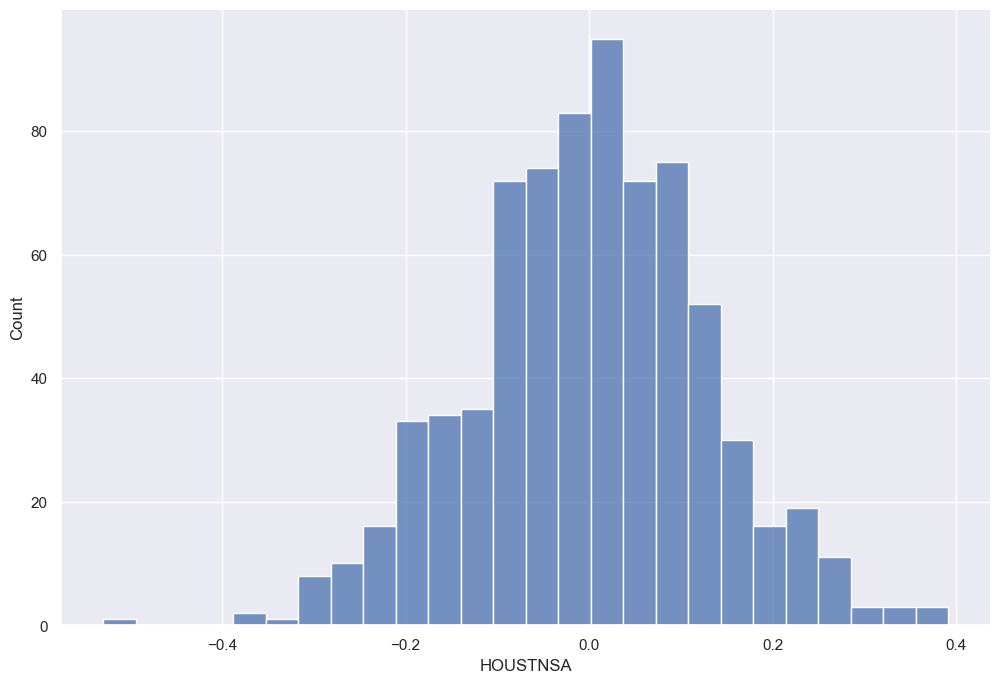

In [44]:
sns.histplot(f2.y)
plt.show()

Call a statistical test to ensure its normality:

In [45]:
critical_pval = 0.05
print('-'*100)
k2, p = stats.normaltest(f2.y.values)
print("D'Agostino and Pearson's test result for normality:")
print('the test-stat value is: {:.2f}'.format(k2))
print('the p-value is {:.4f}'.format(p))
print('the series is {}'.format('not normal' if p < critical_pval else 'normal'))
print('-'*100)

----------------------------------------------------------------------------------------------------
D'Agostino and Pearson's test result for normality:
the test-stat value is: 4.52
the p-value is 0.1043
the series is normal
----------------------------------------------------------------------------------------------------


Call a statistical test to ensure its stationarity:

In [46]:
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f2.adf_test(full_res=True,maxlag=12)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: -11.72
the p-value is 0.0000
the series is stationary
----------------------------------------------------------------------------------------------------


Now, we can check out its periodogram to make sure no further adjustments are needed to the data:

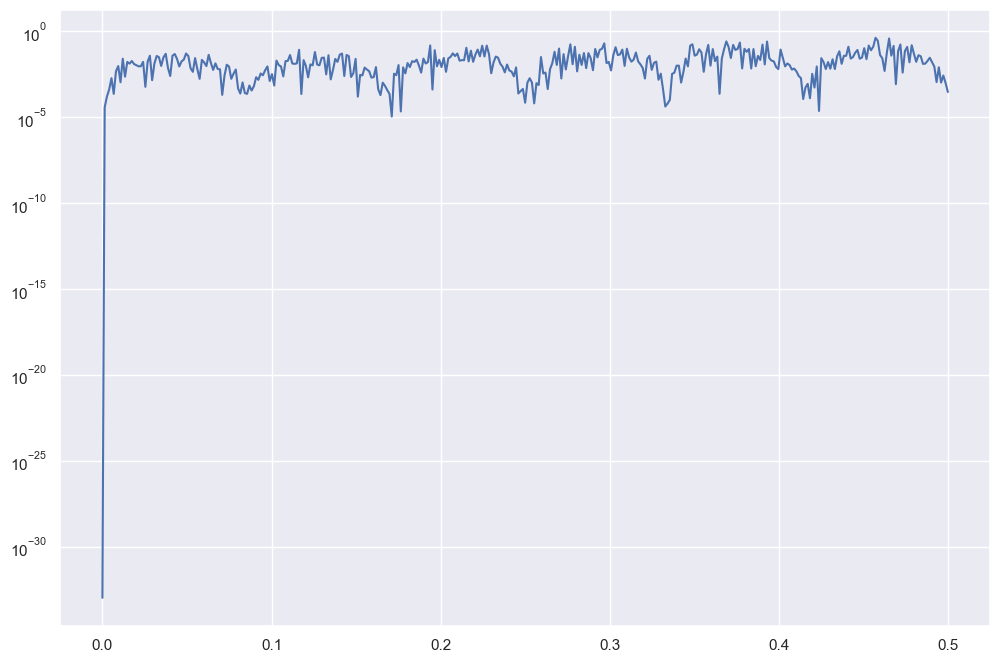

In [47]:
a, b = f2.plot_periodogram()
plt.semilogy(a, b)
plt.show()

This shows that there may be some cycles within the data that show stronger effects than other cycles, but for the most part, the periodogram is pretty stable. We can say that the transformations we took work for our purposes.

Now we can call the method and plot the results:

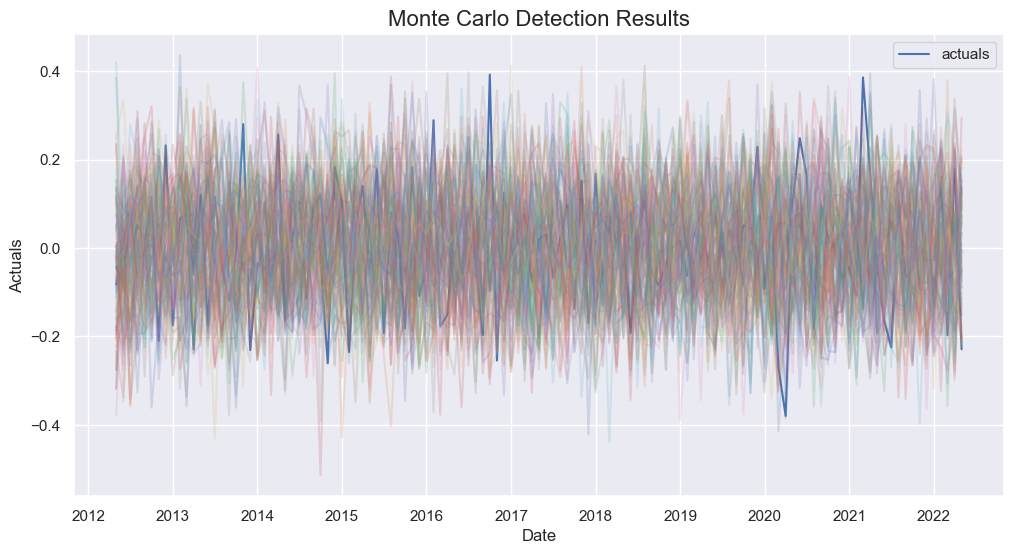

In [49]:
detector.MonteCarloDetect(
    start_at = '2012-05-01',
    stop_at = '2022-05-01',
    cilevel=.99,
)

detector.plot_mc_results()
plt.title('Monte Carlo Detection Results',size=16)
plt.show()

The blue line is the series' actual values and the colored lines are the results of each of 100 monte carlo simulations applied on the last 10 years of data available in the set. The few points that clearly stick above or below all colored lines will most likely be labeled as anomalies.

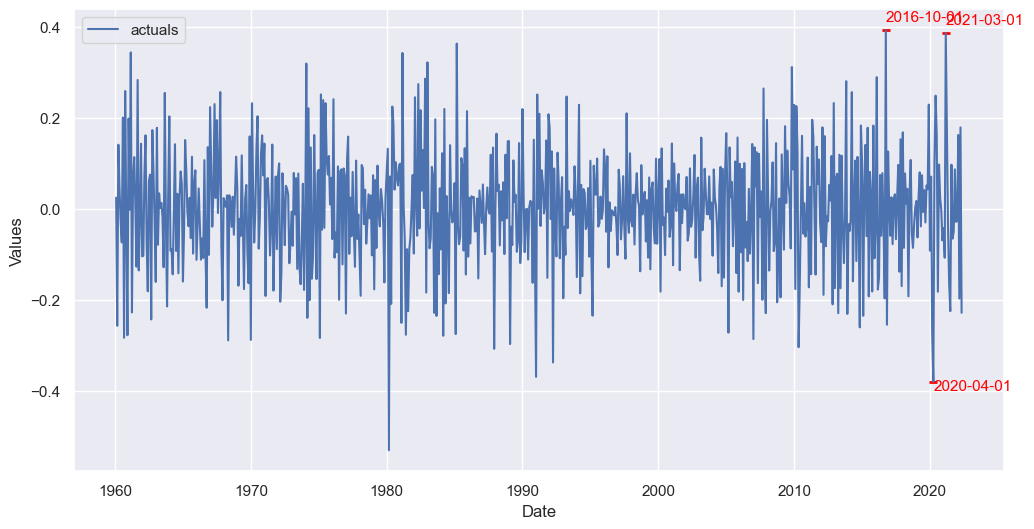

In [50]:
detector.plot_anom()
plt.show()

We see three points identified:
- Oct. 2016  
- April 2020 (first month of the COVID pandemic)  
- March 2021  

We can plot those points back onto our original series:

AttributeError: 'AnomalyDetector' object has no attribute 'labeled_anom'

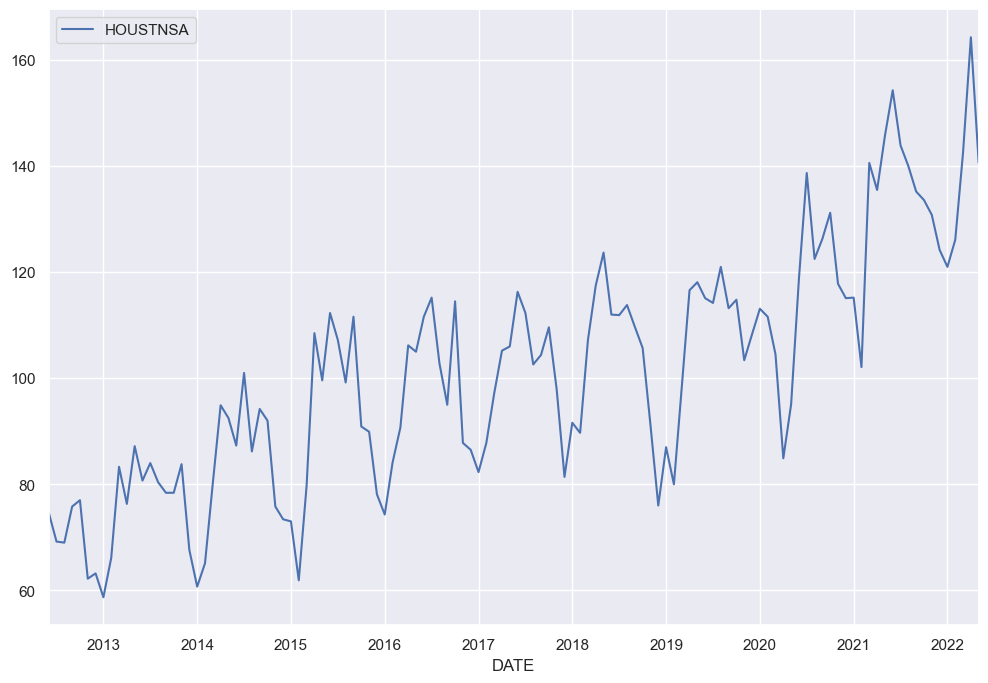

In [53]:
_, ax = plt.subplots()

df.iloc[-120:,:].plot(x='DATE',y='HOUSTNSA',ax=ax)

for i,v in zip(detector2.labeled_anom.index,detecto2r.labeled_anom):
    if v == 1:
        ax.axvline(i,linestyle='--',color='red',alpha=.5)
        ax.text(
            i+pd.Timedelta(days=2),
            60,
            s=i.strftime('%Y-%m-%d'),
            color='red',
            size=11
        )
    
plt.show()

Let's dig into these three points a little more closely.

In [54]:
df2 = df.copy()
df2['year'] = df2.reset_index().DATE.dt.year
df2['month'] = df2.reset_index().DATE.dt.month
df2['pct_chg'] = df2['HOUSTNSA'].pct_change()

In [55]:
avg_chg_month = df2.groupby('month')['pct_chg'].mean().reset_index()
avg_chg_month['pct_chg_std'] = df2.groupby('month')['pct_chg'].std().values
avg_chg_month['pct_chg_2016'] = df2.loc[df2['year'] == 2016,'pct_chg'].values
avg_chg_month['pct_chg_2020'] = df2.loc[df2['year'] == 2020,'pct_chg'].values
avg_chg_month['pct_chg_2021'] = df2.loc[df2['year'] == 2021,'pct_chg'].values

def highlight_rows(row):    

    lightgreen = 'background-color: lightgreen;'
    highlight = 'background-color: lightcoral;'
    default = ''
    
    if row['month'] == 3:
        return [default,lightgreen,lightgreen,default,default,highlight]
    elif row['month'] == 4:
        return [default,lightgreen,lightgreen,default,highlight,default]
    elif row['month'] == 10:
        return [default,lightgreen,lightgreen,highlight,default,default]
    else:
        return [default,lightgreen,lightgreen,default,default,default]

avg_chg_month.style.apply(
    highlight_rows, 
    axis=1
).format(
    {var:'{:.1%}'.format for var in avg_chg_month.iloc[:,1:]}
)

,month,pct_chg,pct_chg_std,pct_chg_2016,pct_chg_2020,pct_chg_2021
0,1,-4.2%,11.9%,-4.9%,4.4%,0.1%
1,2,4.0%,10.9%,13.2%,-1.3%,-11.4%
2,3,32.2%,18.1%,7.8%,-6.4%,37.7%
3,4,13.3%,11.1%,17.1%,-18.8%,-3.6%
4,5,3.9%,8.7%,-1.1%,12.0%,7.5%
5,6,0.6%,8.0%,6.3%,24.9%,5.9%
6,7,-3.4%,7.1%,3.2%,16.8%,-6.7%
7,8,-1.9%,6.9%,-10.8%,-11.7%,-2.7%
8,9,-4.1%,8.2%,-7.6%,3.1%,-3.4%
9,10,2.8%,8.9%,20.5%,3.9%,-1.2%


The reason October 2016 was identified was due to how much more it increased in value from the previous month compared to Octobers from other years. The April 2020 point, as is logical, is from a precipitous decrease in housing starts after the COVID-19 pandemic began. The March 2021 point is the hardest to logically explain, but could be from a large year-over-year increase--a stronger than expected recovery from COVID.

## Monte Carlo Sliding Detect
- Calling the technique on one slice of data only reveals anomalies in that slice. A better way might be to roll the technique across the entire time series
- Below will scan 60-observation chunks and then take a 30-observation step forward to find anomalies across almost the entire series
- Any point identified as an anomaly in this approach will be labeled as such

scanning from obs 60 to obs 120
scanning from obs 90 to obs 150
scanning from obs 120 to obs 180
scanning from obs 150 to obs 210
scanning from obs 180 to obs 240
scanning from obs 210 to obs 270
scanning from obs 240 to obs 300
scanning from obs 270 to obs 330
scanning from obs 300 to obs 360
scanning from obs 330 to obs 390
scanning from obs 360 to obs 420
scanning from obs 390 to obs 450
scanning from obs 420 to obs 480
scanning from obs 450 to obs 510
scanning from obs 480 to obs 540
scanning from obs 510 to obs 570
scanning from obs 540 to obs 600
scanning from obs 570 to obs 630
scanning from obs 600 to obs 660
scanning from obs 630 to obs 690
scanning from obs 660 to obs 720
scanning from obs 690 to obs 750
scanning from obs 720 to obs 780


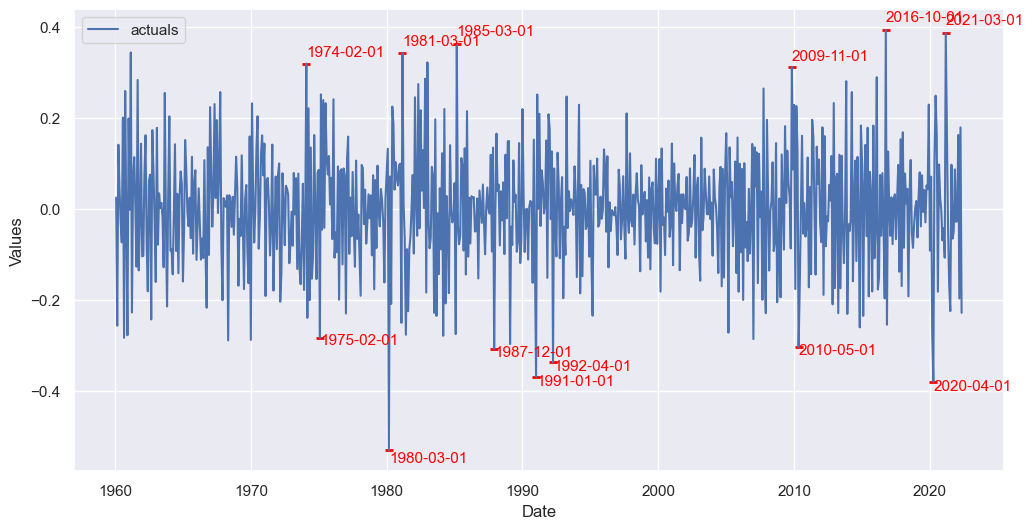

In [56]:
detector.MonteCarloDetect_sliding(60,30)
detector.plot_anom(label=True)
plt.show()

## Adjust Anomalies

### Q-Cutting
- by default, high outliers will be replaced wuth the 90th percentile from the rest of the data
- low outliers with the 10th percentile
- good method for when the data is already normal and stationary without any transformations

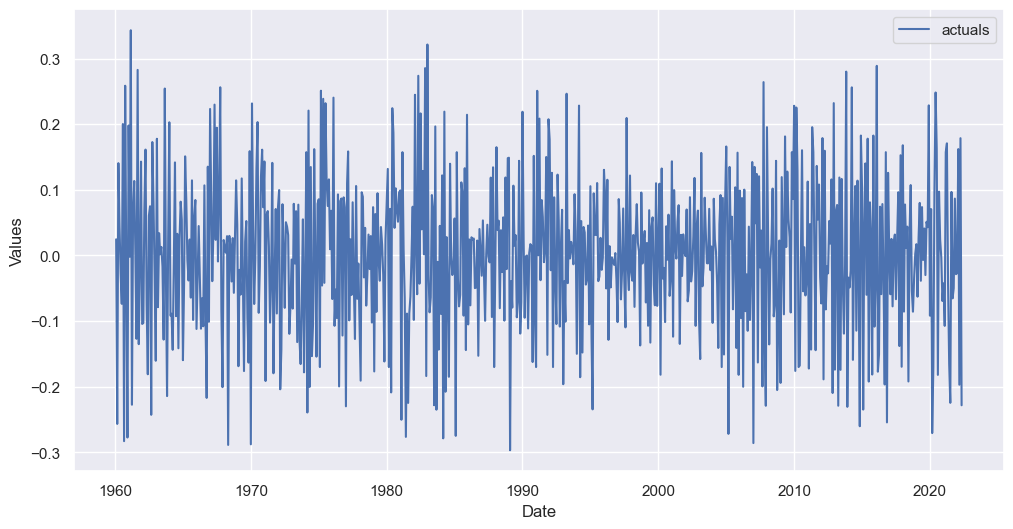

In [57]:
f2 = detector.adjust_anom(method='q')
f2.plot()
plt.show()

## Linear Interpolation
- this is the more sound method for non-stationary data

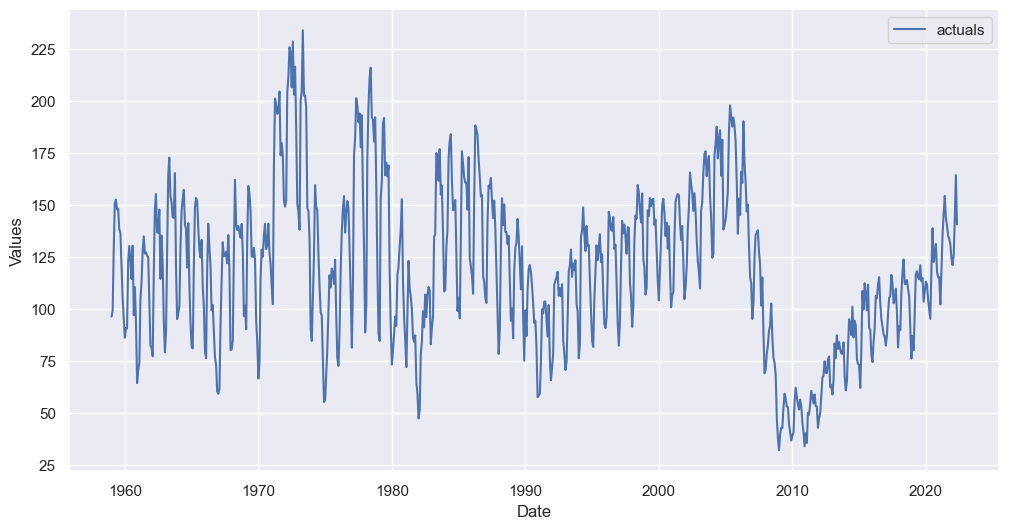

In [58]:
f = detector.adjust_anom(f=f,method='interpolate')
f.plot()
plt.show()